In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import shutil
import tensorflow as tf
import json

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()[1])

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4139778048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11134962303902703455
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419



## Importing Data and DateTime index preparation

In [3]:
df = pd.read_csv("data/bicikelj_train.csv")
# Convert the "timespamp" colum to a datetime object and set it as the index
df = df.set_index("timestamp")
df.index = pd.to_datetime(df.index)

# Count the number of duplicate index values
display(df.index.duplicated().sum())
display(df.head())
display(df.info())

0

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,POGAČARJEV TRG-TRŽNICA,KONGRESNI TRG-ŠUBIČEVA ULICA,CANKARJEVA UL.-NAMA,BREG,GRUDNOVO NABREŽJE-KARLOVŠKA C.,MIKLOŠIČEV PARK,BAVARSKI DVOR,TRG OF-KOLODVORSKA UL.,MASARYKOVA DDC,...,POVŠETOVA - KAJUHOVA,SOSESKA NOVO BRDO,TEHNOLOŠKI PARK,VOJKOVA - GASILSKA BRIGADA,GERBIČEVA - ŠPORTNI PARK SVOBODA,DOLENJSKA C. - STRELIŠČE,ROŠKA - STRELIŠKA,LEK - VEROVŠKOVA,VOKA - SLOVENČEVA,SUPERNOVA LJUBLJANA - RUDNIK
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-02 13:04:00,17,17,20,26,10,10,16,7,12,2,...,9,7,5,4,2,9,4,8,3,1
2022-08-02 13:10:00,18,17,19,25,10,11,15,7,12,4,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:14:00,17,18,19,25,9,11,16,7,12,5,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:20:00,18,15,20,26,12,11,18,6,13,1,...,9,7,5,2,1,9,4,8,2,1
2022-08-02 13:25:00,20,16,19,23,12,10,17,6,15,1,...,9,7,5,2,1,9,4,8,2,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7739 entries, 2022-08-02 13:04:00 to 2022-10-01 18:23:00
Data columns (total 83 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    7739 non-null   int64
 1   POGAČARJEV TRG-TRŽNICA                7739 non-null   int64
 2   KONGRESNI TRG-ŠUBIČEVA ULICA          7739 non-null   int64
 3   CANKARJEVA UL.-NAMA                   7739 non-null   int64
 4   BREG                                  7739 non-null   int64
 5   GRUDNOVO NABREŽJE-KARLOVŠKA C.        7739 non-null   int64
 6   MIKLOŠIČEV PARK                       7739 non-null   int64
 7   BAVARSKI DVOR                         7739 non-null   int64
 8   TRG OF-KOLODVORSKA UL.                7739 non-null   int64
 9   MASARYKOVA DDC                        7739 non-null   int64
 10  VILHARJEVA CESTA                      7739 non-null   int64
 11  PARK NA

None

## Creating a DataFrame for each station

In [4]:
# Split the dataframe into multiple dataframes, each with one station
df_list = [df[[station]] for station in df.columns]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE
timestamp,
2022-08-02 13:04:00,17
2022-08-02 13:10:00,18
2022-08-02 13:14:00,17
2022-08-02 13:20:00,18
2022-08-02 13:25:00,20


### Data distribution of one station

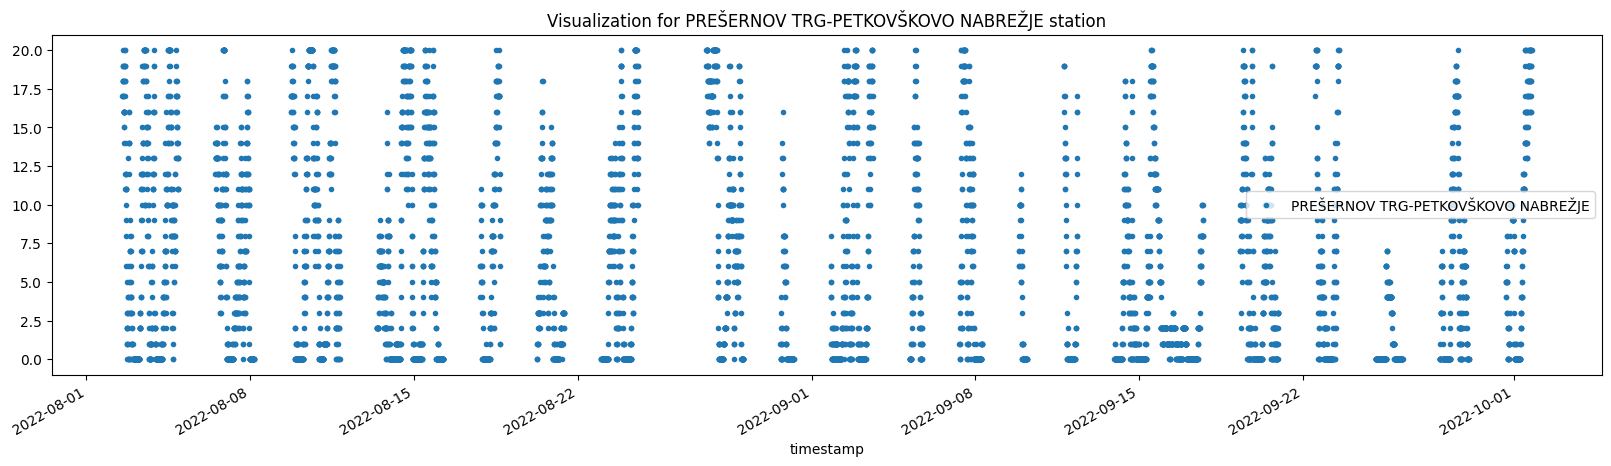

In [5]:
ig, ax = plt.subplots(figsize=(20, 5))
df_list[0].plot(ax=ax, label='Training Set', title=f"Visualization for {df_list[0].columns[0]} station", style=".")
plt.show()

# Feature creation

## Features created from datetime index (hour, dayofweek, month, dayofyear, dayofmonth)

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df_list = [create_features(station) for station in df_list]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth
timestamp,,,,,,
2022-08-02 13:04:00,17,13,1,8,214,2
2022-08-02 13:10:00,18,13,1,8,214,2
2022-08-02 13:14:00,17,13,1,8,214,2
2022-08-02 13:20:00,18,13,1,8,214,2
2022-08-02 13:25:00,20,13,1,8,214,2


## Lag features (60, (90) and 120 min lag)

In [7]:
def add_lags(df):
    df = df.copy()
    # Create 60, 90 and 120 minutes lags
    # lags = [60, 90, 120]
    lags = [60, 120]
    for lag in lags:
        df_lag = df.copy()
        # Drop all but the target column
        df_lag = df_lag[[df.columns[0]]]
        # Subtract 60 minutes from the index
        df_lag.index = df_lag.index + pd.Timedelta(minutes=lag)
        # Rename the column to "lag_60"
        df_lag.columns = [f"lag_{lag}"]
        # Merge the dataframe with the lagged dataframe
        df = pd.merge_asof(
            df,
            df_lag,
            left_index=True,
            right_index=True,
            direction="nearest",
            tolerance=pd.Timedelta("15m"),
        )
    return df

df_list = [add_lags(station) for station in df_list]
display(df_list[0].tail())
display(df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120
timestamp,,,,,,,,
2022-10-01 18:03:00,18,18,5,10,274,1,20.0,19.0
2022-10-01 18:07:00,20,18,5,10,274,1,20.0,19.0
2022-10-01 18:13:00,19,18,5,10,274,1,20.0,18.0
2022-10-01 18:16:00,19,18,5,10,274,1,20.0,18.0
2022-10-01 18:23:00,20,18,5,10,274,1,20.0,18.0


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE      0
hour                                    0
dayofweek                               0
month                                   0
dayofyear                               0
dayofmonth                              0
lag_60                                191
lag_120                               419
dtype: int64

In [8]:
df_list[0].to_csv("data/other/processed.csv")

## School day feature (0 for holidays and weekends, 1 for school days)

In [9]:
def add_school_days(df):
    # Add vacation feature which is 1 if the day is a school vacation day and 0 otherwise
    # School days are from 1.9.2022 to 31.10.2022 without weekends
    df["vacation"] = 0
    df.loc[(df.index >= "2022-09-01") & (df.index <= "2022-10-31") & (df.index.dayofweek < 5), "vacation"] = 1
    return df

df_list = [add_school_days(station) for station in df_list]
display(df_list[0].tail())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120,vacation
timestamp,,,,,,,,,
2022-10-01 18:03:00,18,18,5,10,274,1,20.0,19.0,0
2022-10-01 18:07:00,20,18,5,10,274,1,20.0,19.0,0
2022-10-01 18:13:00,19,18,5,10,274,1,20.0,18.0,0
2022-10-01 18:16:00,19,18,5,10,274,1,20.0,18.0,0
2022-10-01 18:23:00,20,18,5,10,274,1,20.0,18.0,0


## Weather feature (Amount of rain in mm)

In [10]:
weather = pd.read_csv("data/extra/padavine_polurno.csv")
weather = weather.drop(columns=["station_id", "station_name"])
weather["datum"] = pd.to_datetime(weather["datum"])
weather = weather.set_index("datum")
weather.info()

def add_weather(df, weather):
    df = df.copy()
    weather = weather.copy()
    # Add weather features by matrhing the Date, Hour of the day and the station
    return pd.merge_asof(
        df,
        weather,
        left_index=True,
        right_index=True,
        direction="nearest",
    )

df_list = [add_weather(station, weather) for station in df_list]
display(df_list[0].tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2022-08-01 00:00:00 to 2022-10-01 23:30:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   padavine  2976 non-null   float64
dtypes: float64(1)
memory usage: 46.5 KB


,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120,vacation,padavine
timestamp,,,,,,,,,,
2022-10-01 18:03:00,18,18,5,10,274,1,20.0,19.0,0,0.0
2022-10-01 18:07:00,20,18,5,10,274,1,20.0,19.0,0,0.0
2022-10-01 18:13:00,19,18,5,10,274,1,20.0,18.0,0,0.0
2022-10-01 18:16:00,19,18,5,10,274,1,20.0,18.0,0,0.0
2022-10-01 18:23:00,20,18,5,10,274,1,20.0,18.0,0,0.0


In [11]:
df_list[0].to_csv("data/other/processed.csv")

# Split the data into 60 min and 120 min lag

In [12]:
# # From the dataframes make two dataframes, one with all the features and 60 minutes lag and one with 120 minutes lag
df_list_60 = [station.drop(columns=["lag_120"]) for station in df_list]
df_list_120 = [station.drop(columns=["lag_60"]) for station in df_list]

# Hyperparameter tuning

### Create training and test sets

In [13]:
# Drop the na values
df_list_60 = [station.dropna() for station in df_list_60]
df_list_120 = [station.dropna() for station in df_list_120]

# Split the dataframes into training and validation sets
df_list_60_train = [station.iloc[:-1500] for station in df_list_60]
df_list_60_val = [station.iloc[-1500:] for station in df_list_60]

df_list_120_train = [station.iloc[:-1500] for station in df_list_120]
df_list_120_val = [station.iloc[-1500:] for station in df_list_120]

In [14]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int("units", min_value=96, max_value=480, step=96), return_sequences=True, input_shape=(df_list_60_train[0].shape[1] - 1, 1)))
    model.add(Dropout(hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)))
    for i in range(hp.Int("n_layers", 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=96,max_value=480,step=96),return_sequences=True))
        model.add(Dropout(hp.Float(f'lstm_{i}_dropout',min_value=0.1,max_value=0.5,step=0.1)))
    model.add(LSTM(units=hp.Int("units", min_value=32, max_value=480, step=96)))
    model.add(Dropout(hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mean_absolute_error"])
    return model

In [15]:
tuner = RandomSearch(
    build_model,
    objective="val_mean_absolute_error",
    seed=42,
    overwrite=True,
    max_trials=5,
    executions_per_trial=1,
    directory="data/LSTMtuner"
)

In [39]:
best_hyperparameters_60 = []
for station in df_list_60_train:
    tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error",
        seed=42,
        overwrite=True,
        max_trials=5,
        executions_per_trial=1,
        directory="data/LSTMtuner"
    )
    X_train = station.drop(columns=[station.columns[0]])
    y_train = station[station.columns[0]]
    X_val = station.drop(columns=[station.columns[0]])
    y_val = station[station.columns[0]]
    tuner.search(np.asarray(X_train), np.asarray(y_train), epochs=5, batch_size=128, validation_data=(np.asarray(X_val), np.asarray(y_val)))
    best_hyperparameters_60.append(tuner.get_best_hyperparameters()[0].values)
    print(f"{station.columns[0]} done")
    shutil.rmtree("data/LSTMtuner/untitled_project")

Trial 5 Complete [00h 00m 13s]
val_mean_absolute_error: 0.6735254526138306

Best val_mean_absolute_error So Far: 0.6735254526138306
Total elapsed time: 00h 01m 03s
INFO:tensorflow:Oracle triggered exit
SUPERNOVA LJUBLJANA - RUDNIK done


In [40]:
# Store the best hyperparameters
with open("hyperparameters/best_hyperparameters_60.json", "w") as f:
    json.dump(best_hyperparameters_60, f)

In [41]:
best_hyperparameters_120 = []
for station in df_list_120_train:
    tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error",
        seed=42,
        overwrite=True,
        max_trials=5,
        executions_per_trial=1,
        directory="data/LSTMtuner"
    )
    X_train = station.drop(columns=[station.columns[0]])
    y_train = station[station.columns[0]]
    X_val = station.drop(columns=[station.columns[0]])
    y_val = station[station.columns[0]]
    tuner.search(np.asarray(X_train), np.asarray(y_train), epochs=5, batch_size=128, validation_data=(np.asarray(X_val), np.asarray(y_val)))
    best_hyperparameters_120.append(tuner.get_best_hyperparameters()[0].values)
    print(f"{station.columns[0]} done")
    shutil.rmtree("data/LSTMtuner/untitled_project")


Trial 5 Complete [00h 00m 13s]
val_mean_absolute_error: 0.9862462282180786

Best val_mean_absolute_error So Far: 0.9307436943054199
Total elapsed time: 00h 01m 05s
INFO:tensorflow:Oracle triggered exit


SUPERNOVA LJUBLJANA - RUDNIK done


In [42]:
# Store the best hyperparameters
with open("hyperparameters/best_hyperparameters_120.json", "w") as f:
    json.dump(best_hyperparameters_120, f)

### Reading the best hyperparameters

In [16]:
# Read the best hyperparameters from the json files
best_hyperparameters_120 = []
with open("hyperparameters/best_hyperparameters_120.json", "r") as f:
    best_hyperparameters_120 = json.load(f)

best_hyperparameters_60 = []
with open("hyperparameters/best_hyperparameters_60.json", "r") as f:
    best_hyperparameters_60 = json.load(f)

In [17]:
best_hyperparameters_60_params = []
for hyperparameter in best_hyperparameters_60:
    best_hyperparameters = HyperParameters()
    best_hyperparameters.values = hyperparameter
    best_hyperparameters_60_params.append(best_hyperparameters)

best_hyperparameters_120_params = []
for hyperparameter in best_hyperparameters_120:
    best_hyperparameters = HyperParameters()
    best_hyperparameters.values = hyperparameter
    best_hyperparameters_120_params.append(best_hyperparameters)

## Training the model on the whole dataset (One for each station)

In [18]:
def train_models(df_list, best_hyperparameters):
    models = []
    for hyperparameters, station in zip(best_hyperparameters, df_list):

        # Drop all rows with NaN values
        station = station.dropna()

        FEATURES = station.columns[1:]
        TARGET = station.columns[0]
        
        X_all = station[FEATURES]
        y_all = station[TARGET]

        # Build the model with the best hyperparameters
        model = tuner.hypermodel.build(hyperparameters)
        
        model.fit(X_all, y_all,
                batch_size=128,
                epochs=10,
                verbose=1,
                workers=4,
                use_multiprocessing=True
                )
        
        models.append(model)
        print(f"{station.columns[0]} done")
    return models

In [22]:
models_60 = train_models(df_list_60, best_hyperparameters_60_params)

Epoch 1/10
59/59 [==============================] - 10s 25ms/step - loss: 4.5206 - mean_absolute_error: 4.5206
Epoch 2/10
59/59 [==============================] - 1s 20ms/step - loss: 3.9014 - mean_absolute_error: 3.9014
Epoch 3/10
59/59 [==============================] - 1s 19ms/step - loss: 2.8832 - mean_absolute_error: 2.8832
Epoch 4/10
59/59 [==============================] - 1s 20ms/step - loss: 2.5236 - mean_absolute_error: 2.5236
Epoch 5/10
59/59 [==============================] - 1s 19ms/step - loss: 2.4074 - mean_absolute_error: 2.4074
Epoch 6/10
59/59 [==============================] - 1s 19ms/step - loss: 2.3735 - mean_absolute_error: 2.3735
Epoch 7/10
59/59 [==============================] - 1s 19ms/step - loss: 2.3597 - mean_absolute_error: 2.3597
Epoch 8/10
59/59 [==============================] - 1s 19ms/step - loss: 2.4035 - mean_absolute_error: 2.4035
Epoch 9/10
59/59 [==============================] - 1s 19ms/step - loss: 2.4009 - mean_absolute_error: 2.4009
Epoch 10/

In [19]:
models_120 = train_models(df_list_120, best_hyperparameters_120_params)

Epoch 1/10
58/58 [==============================] - 9s 21ms/step - loss: 4.5508 - mean_absolute_error: 4.5508
Epoch 2/10
58/58 [==============================] - 1s 17ms/step - loss: 3.7251 - mean_absolute_error: 3.7251
Epoch 3/10
58/58 [==============================] - 1s 17ms/step - loss: 3.2851 - mean_absolute_error: 3.2851
Epoch 4/10
58/58 [==============================] - 1s 17ms/step - loss: 3.0272 - mean_absolute_error: 3.0272
Epoch 5/10
58/58 [==============================] - 1s 17ms/step - loss: 2.9818 - mean_absolute_error: 2.9818
Epoch 6/10
58/58 [==============================] - 1s 17ms/step - loss: 2.9431 - mean_absolute_error: 2.9431
Epoch 7/10
58/58 [==============================] - 1s 17ms/step - loss: 2.9177 - mean_absolute_error: 2.9177
Epoch 8/10
58/58 [==============================] - 1s 17ms/step - loss: 2.9409 - mean_absolute_error: 2.9409
Epoch 9/10
58/58 [==============================] - 1s 17ms/step - loss: 2.9543 - mean_absolute_error: 2.9543
Epoch 10/1

## Preparing the test data for prediction

In [20]:
# Reading and preparing the test data
df_test = pd.read_csv("data/bicikelj_test.csv")
df_test = df_test.set_index("timestamp")
df_test.index = pd.to_datetime(df_test.index)
df_test = df_test.sort_index()

# Create a list of dataframes, one for each station for the test and train set
df_train_list = [df[[station]] for station in df.columns]
df_test_list = [df_test[[station]] for station in df_test.columns]

# Add the "Test" column to the dataframes
df_train_list = [station.assign(Test=False) for station in df_train_list]
df_test_list = [station.assign(Test=True) for station in df_test_list]

test_df_list = []
for train, test in zip(df_train_list, df_test_list):
        # Concatenate the two dataframes
        train_n_test = pd.concat([train, test], axis=0)
        train_n_test = train_n_test.sort_index()
        # Add the lags and datetime features
        train_n_test = create_features(train_n_test)
        train_n_test = add_lags(train_n_test)
        train_n_test = add_school_days(train_n_test)
        train_n_test = add_weather(train_n_test, weather)
        # Select only the rows which are in the test set
        station_test = train_n_test[train_n_test["Test"] == True]
        # Drop the "Test" column
        station_test = station_test.drop("Test", axis=1)
        # Add the dataframe to the list
        test_df_list.append(station_test)

display(test_df_list[0].head())
display(test_df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag_60,lag_120,vacation,padavine
timestamp,,,,,,,,,,
2022-08-04 23:24:00,NaN,23,3,8,216,4,11.0,14.0,0,0.0
2022-08-05 00:24:00,NaN,0,4,8,217,5,NaN,11.0,0,0.0
2022-08-08 04:58:00,NaN,4,0,8,220,8,0.0,0.0,0,0.0
2022-08-08 05:58:00,NaN,5,0,8,220,8,NaN,0.0,0,0.0
2022-08-11 21:13:00,NaN,21,3,8,223,11,4.0,2.0,0,0.0


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    40
hour                                   0
dayofweek                              0
month                                  0
dayofyear                              0
dayofmonth                             0
lag_60                                20
lag_120                                0
vacation                               0
padavine                               0
dtype: int64

In [21]:
# Make a list of dataframes from rows where lag_60 is not null
df_list_60 = [station[station["lag_60"].notnull()] for station in test_df_list]
# Remove the lag_120 column 
df_list_60 = [station.drop("lag_120", axis=1) for station in df_list_60]

# Make a list of dataframes from rows where lag_60 is null
df_list_120 = [station[station["lag_60"].isnull()] for station in test_df_list]
# Remove the lag_60 column
df_list_120 = [station.drop("lag_60", axis=1) for station in df_list_120]

## Predicting the test data

In [22]:
def make_predictions(models, df_list):
    preds_list = []
    for model, station in zip(models, df_list):
        # Get the predictions for the station
        pred = model.predict(station[station.columns[1:]])
        # Transform the predictions to integers
        pred = pred.round(0).astype(np.int64)
        # Add the predictions to the list
        preds_list.append(pred)
    return preds_list

In [23]:
# Make the predictions
preds_list_60 = make_predictions(models_60, df_list_60)
preds_list_120 = make_predictions(models_120, df_list_120)

1/1 [==============================] - 1s 1s/step


In [24]:
# # Store the predictions in a pickle file
# import pickle

# with open("data/temp/predictions_60.pkl", "wb") as f:
#     pickle.dump(preds_list_60, f)


# with open("data/temp/predictions_120.pkl", "wb") as f:
#     pickle.dump(preds_list_120, f)

In [25]:
# # Read the predictions from the file
# import pickle
# with open("data/temp/predictions_LSTM_60.pkl", "rb") as f:
#     preds_list_60 = pickle.load(f)

In [26]:
# Combine the predictions for 60 and 120 minutes into one list
preds_list_merged = []
for pred_60, pred_120 in zip(preds_list_60, preds_list_120):
    pred = []
    for i in range(len(pred_120)):
        pred.append(pred_60[i][0])
        pred.append(pred_120[i][0])
    preds_list_merged.append(pred)    

In [27]:
# Add the predictions to the test set
predicted = pd.read_csv("data/bicikelj_test.csv")
stations = predicted.columns[1:]
for station, pred in zip(stations, preds_list_merged):
        predicted[station] = pred

predicted.to_csv("data/predictions/predicted_LSTM_tuned.csv", index=False)

In [ ]:
# import pickle
# with open("models/models_LSTM_60.pkl", "wb") as f:
#     pickle.dump(models_60, f)

# with open("models/models_LSTM_120.pkl", "wb") as f:
#     pickle.dump(models_120, f)